In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

# SCALES low-res SED example

This notebook runs through all the steps for generating a raw SCALES image using either:

(1) a target spectrum in erg/s/cm^2/um + a PSF
OR
(2) a model datacube with fluxes in erg/s/cm^2/um

You don't need to change any of the configuration stuff at the beginning if you don't want to. There are comments that describe some parameters that you might be interested in adjusting.

This example just uses PHOENIX models to set up simple stellar targets as "Target" objects. It then uses PHOENIX models to make an example model datacube that you can feed to the simulator. You can replace that with whatever scene you like, as long as the dimensions match the number of spaxels in each dimension (108 by 108), and the flux units are erg/s/cm^2/um. 

In the end it does a simple aperture extraction to generate a datacube. 

# SET UP OBSERVING MODE AND SCENE HERE

In [2]:
###Set your minimum and maximum wavelengths (in microns) here. 
###Realistic options (corresponding to planned modes) are: 2.0-5.2, 1.95-2.45, 2.0-4.0, 2.9-4.15, 3.1-3.5, 4.5-5.2 
wav_min = 2.9
wav_max = 4.15

###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)
print(wav)
print(I_lam)

####set this up as a Target
targ = Target(wav,I_lam)

###Set up a scene instead of assuming a single point source with a spectrum
##make spectrum first
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

lams_binned=np.linspace(1.9,5.3,3401) ###do not change
I_lam2 = spectres(lams_binned,wav,I_lam)

##create empty cube for scene
scene = np.zeros([len(lams_binned),17,18])

##central point source
scene[:,9,9] = I_lam2

##equal contrast companion
scene[:,14,14] = I_lam2


[0.05     0.05001  0.05002  ... 5.499925 5.49995  5.499975]
[1.2782357e-17 1.2860824e-17 1.2958242e-17 ... 1.2565723e-10 1.2565281e-10
 1.2564963e-10]


## Configure your H2RG

Load in h2rg configuration file 

In [3]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=2048, naxis2=2048,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [4]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [5]:
config.read('scales_h2rg_med.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

In [6]:
arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns

## Set up lenslet traces

In [7]:
lens = Lenslet(arg_spaxel, medium=True)
lens.get_shifts(rot = 0.0)
lens.make_trace(phys=True,verbose=True,upsample_factor=10)

2.9_4.15_prism.txt
2.9_4.15_grism.txt


## Read in Keck pupil

In [8]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [9]:
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.8, 500e-9)
screen1 = screen.get_res()
#screen1 = np.zeros(screen1.shape)

## Use pupil and residual phase to generate cube of Keck PSFs

In [15]:
nspax = arg_spaxel['no_spaxel']
nlam = lens.trace.shape[0]

keck_cube = np.zeros((nlam, nspax-1, nspax))
mag1 = magn(lens.lmin)
mag2 = magn(lens.lmax)

psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'_med.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        print(i)
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))[45:62,45:63]
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)
print(keck_cube.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [11]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
filt = Filter(lmin=lens.lmin,lmax=lens.lmax)
dit = 1 ###integration time in seconds

In [12]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Generate raw SCALES frame using target + PSF

making full raw image
nspax =  18
0
0 0
0.0 -0.7727272727279342
(1912, 12)
0 0
12 1912
0 1
0.0 -0.7727272727279342
(1912, 12)
18 0
30 1912
0 2
0.0 -0.7727272727279342
(1912, 12)
36 0
48 1912
0 3
0.0 -0.7727272727279342
(1912, 12)
54 0
66 1912
0 4
0.0 -0.7727272727279342
(1912, 12)
72 0
84 1912
0 5
0.0 -0.7727272727279342
(1912, 12)
90 0
102 1912
0 6
0.0 -0.7727272727279342
(1912, 12)
108 0
120 1912
0 7
0.0 -0.7727272727279342
(1912, 12)
126 0
138 1912
0 8
0.0 -0.7727272727279342
(1912, 12)
144 0
156 1912
0 9
0.0 -0.7727272727279342
(1912, 12)
162 0
174 1912
0 10
0.0 -0.7727272727279342
(1912, 12)
180 0
192 1912
0 11
0.0 -0.7727272727279342
(1912, 12)
198 0
210 1912
0 12
0.0 -0.7727272727279342
(1912, 12)
216 0
228 1912
0 13
0.0 -0.7727272727279342
(1912, 12)
234 0
246 1912
0 14
0.0 -0.7727272727279342
(1912, 12)
252 0
264 1912
0 15
0.0 -0.7727272727279342
(1912, 12)
270 0
282 1912
0 16
0.0 -0.7727272727279342
(1912, 12)
288 0
300 1912
1
1 0
0.0 -0.10606060606127699
(1912, 12)
12 166
24

0.0 -0.4393939393946056
(1912, 12)
1698 83
1710 1995
8 10
0.0 -0.4393939393946056
(1912, 12)
1716 83
1728 1995
8 11
0.0 -0.4393939393946056
(1912, 12)
1734 83
1746 1995
8 12
0.0 -0.4393939393946056
(1912, 12)
1752 83
1764 1995
8 13
0.0 -0.4393939393946056
(1912, 12)
1770 83
1782 1995
8 14
0.0 -0.4393939393946056
(1912, 12)
1788 83
1800 1995
8 15
0.0 -0.4393939393946056
(1912, 12)
1806 83
1818 1995
8 16
0.0 -0.4393939393946056
(1912, 12)
1824 83
1836 1995
9
9 0
0.0 -0.7727272727279342
(1912, 12)
1530 0
1542 1912
9 1
0.0 -0.7727272727279342
(1912, 12)
1548 0
1560 1912
9 2
0.0 -0.7727272727279342
(1912, 12)
1566 0
1578 1912
9 3
0.0 -0.7727272727279342
(1912, 12)
1584 0
1596 1912
9 4
0.0 -0.7727272727279342
(1912, 12)
1602 0
1614 1912
9 5
0.0 -0.7727272727279342
(1912, 12)
1620 0
1632 1912
9 6
0.0 -0.7727272727279342
(1912, 12)
1638 0
1650 1912
9 7
0.0 -0.7727272727279342
(1912, 12)
1656 0
1668 1912
9 8
0.0 -0.7727272727279342
(1912, 12)
1674 0
1686 1912
9 9
0.0 -0.7727272727279342
(1912, 

0.0 -0.7727272727279342
(1912, 12)
576 0
588 1912
16 16
0.0 -0.7727272727279342
(1912, 12)
594 0
606 1912
17
17 0
0.0 -0.4393939393946056
(1912, 12)
6 83
18 1995
17 1
0.0 -0.4393939393946056
(1912, 12)
24 83
36 1995
17 2
0.0 -0.4393939393946056
(1912, 12)
42 83
54 1995
17 3
0.0 -0.4393939393946056
(1912, 12)
60 83
72 1995
17 4
0.0 -0.4393939393946056
(1912, 12)
78 83
90 1995
17 5
0.0 -0.4393939393946056
(1912, 12)
96 83
108 1995
17 6
0.0 -0.4393939393946056
(1912, 12)
114 83
126 1995
17 7
0.0 -0.4393939393946056
(1912, 12)
132 83
144 1995
17 8
0.0 -0.4393939393946056
(1912, 12)
150 83
162 1995
17 9
0.0 -0.4393939393946056
(1912, 12)
168 83
180 1995
17 10
0.0 -0.4393939393946056
(1912, 12)
186 83
198 1995
17 11
0.0 -0.4393939393946056
(1912, 12)
204 83
216 1995
17 12
0.0 -0.4393939393946056
(1912, 12)
222 83
234 1995
17 13
0.0 -0.4393939393946056
(1912, 12)
240 83
252 1995
17 14
0.0 -0.4393939393946056
(1912, 12)
258 83
270 1995
17 15
0.0 -0.4393939393946056
(1912, 12)
276 83
288 1995
1

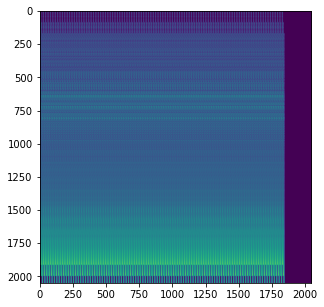

In [14]:
#raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube,medium=True, verbose=True)
raw, bg_star_truth = fp.get_fp(dit*u.s,return_full=True,medium=True,verbose=True)
rawfile = 'raw_frame_med_L.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw**0.25)
plt.show()